In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
    def BuildModel_SegNet():
        inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

        conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
        conv_1_1 = Activation('relu')(conv_1_1)
        conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
        conv_1_2 = Activation('relu')(conv_1_2)
        pool_1 = MaxPooling2D(2)(conv_1_2)

        conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
        conv_2_1 = Activation('relu')(conv_2_1)
        conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
        conv_2_2 = Activation('relu')(conv_2_2)
        pool_2 = MaxPooling2D(2)(conv_2_2)

        conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
        conv_3_1 = Activation('relu')(conv_3_1)
        conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
        conv_3_2 = Activation('relu')(conv_3_2)
        pool_3 = MaxPooling2D(2)(conv_3_2)

        up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
        conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
        conv_up_1_1 = Activation('relu')(conv_up_1_1)
        conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
        conv_up_1_2 = Activation('relu')(conv_up_1_2)

        up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
        conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
        conv_up_2_1 = Activation('relu')(conv_up_2_1)
        conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
        conv_up_2_2 = Activation('relu')(conv_up_2_2)

        up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
        conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
        conv_up_3_1 = Activation('relu')(conv_up_3_1)
        conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
        result = Activation('sigmoid')(conv_up_3_2)

        return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_SegNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


def BuildModel_UNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conc_1 = Concatenate()([conv_3_2, up_1])
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_2_2, up_2])
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_1_2, up_3])
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_UNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

In [2]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		10000
Number of files in Validation-set:	2000


img_df = data.train.image_paths
mask_df = data.train.masks_paths
batch_size = 26

index = 0
while index < 5:
    x_batch = []
    y_batch = []
    r_batch = []

    for i in range(batch_size):
        img_name = img_df[index]
        mask_name = mask_df[index]

#             print(index, img_name, mask_name)

        index = (index + 1) % len(img_df)

        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

#             img, mask

        img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
        mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

        height, width = mask.shape
        masks = np.zeros((height, width, 4))
        for i in range(masks.shape[2]):
            masks[:, :, i] = (mask == (i+1))

        #moving the channel:
        mask_train = np.moveaxis(masks,-1,1)

        x_batch += [img]
        y_batch.append(mask_train)
        r_batch += [mask]

    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.
    r_batch = np.array(r_batch) / 255.

x_batch.shape,y_batch.shape,r_batch.shape

In [3]:
def read_image_with_mask(img_name, mask_name):
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            
#     img, mask
            
    img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
    mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

    height, width = mask.shape
    masks = np.zeros((height, width, 4))
    for i in range(masks.shape[2]):
        masks[:, :, i] = (mask == (i+1))
            
#     masks = np.moveaxis(masks,-1,1)

    return img / 255., masks / 1.

def prepare_image_and_mask_for_prediction(img_name, mask_name):
    img, masks = read_image_with_mask(img_name, mask_name)
    return np.array([img]), np.array([masks])

def keras_generator(img_df, mask_df, batch_size):
    index = 0
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name = img_df[index]
            mask_name = mask_df[index]
            
#             print(index, img_name, mask_name)
            
            index = (index + 1) % len(img_df)
            
            img, masks = read_image_with_mask(img_name, mask_name)
            
            x_batch += [img]
            y_batch.append(masks)

        
#         print(x_batch.shape,y_batch.shape)

        yield np.array(x_batch), np.array(y_batch)

In [5]:
batch_size = 16
model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=300,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=100,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
300/300 [==============================] - 2042s 7s/step - loss: 0.5011 - val_loss: 0.3211
Epoch 2/3
300/300 [==============================] - 2035s 7s/step - loss: 0.2590 - val_loss: 0.2389
Epoch 3/3
300/300 [==============================] - 2041s 7s/step - loss: 0.2159 - val_loss: 0.2012


from keras.models import load_model

model1 = BuildModel_SegNet()
model1.load_weights('unet_best.h5')
# model1 = load_model('unet_best.h5')

In [4]:
from keras.models import load_model
model1 = load_model('segnet_best.h5')
# model1 = load_model('unet_best.h5')

In [5]:
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, 16):
    break

In [6]:
pred = model1.predict(x)

pred[:,:,:,2] *= 2

In [7]:
def getClassesMap(pred):
    res = np.zeros((pred.shape[0], pred.shape[1]), np.uint8)
    for r in range(pred.shape[0]):
        for c in range(pred.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            res[r,c] = pred_class_index
    res.shape
    return res

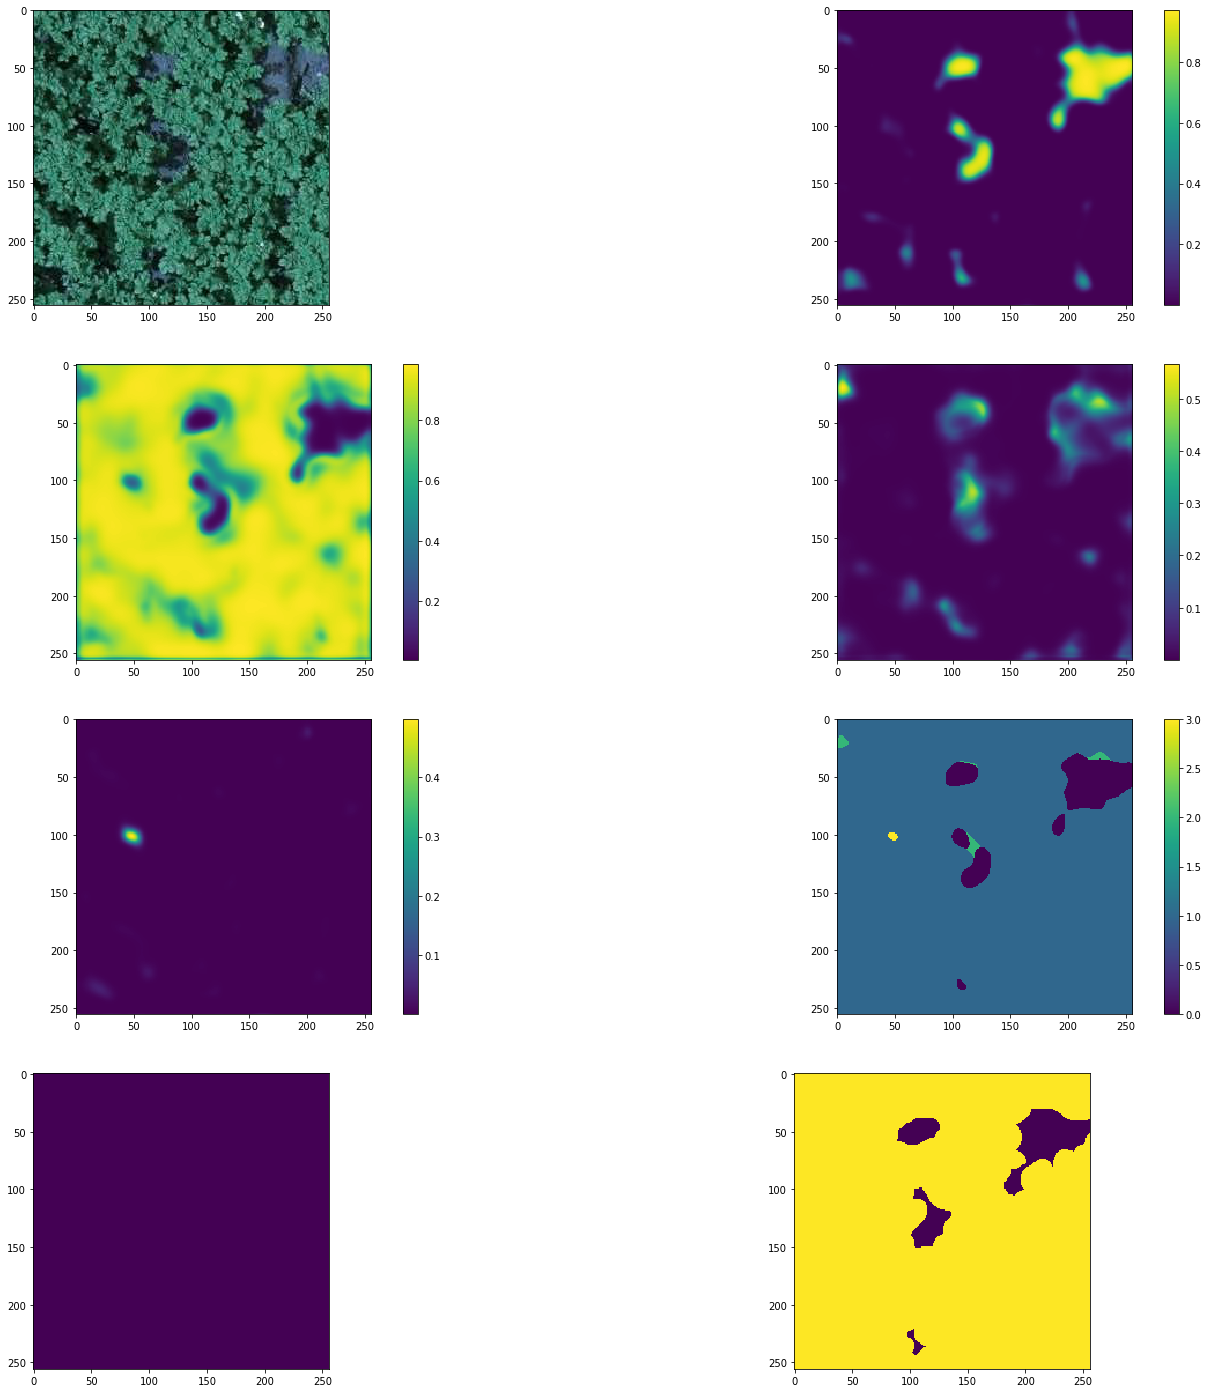

In [23]:
sample_index = 15
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
im_0_1 = axes[0][1].imshow(pred[sample_index, ..., 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, ..., 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, ..., 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, ..., 3])
# im_2_1 = axes[2][1].imshow(keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).astype(np.float32))
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
# im_2_1 = axes[2][1].imshow(pred[sample_index, 20:40, 0:5, 0])
im_3_0 = axes[3][0].imshow(y[sample_index, ..., 2])
im_3_1 = axes[3][1].imshow(y[sample_index, ..., 1])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

In [24]:
def CountErrors(y, pred):
    ok_cnt = 0
    required = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
    }
    valid = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    errors = {
        0: [0,0,0,0],
        1: [0,0,0,0],
        2: [0,0,0,0],
        3: [0,0,0,0],
    }
    
    for r in range(y.shape[0]):
        for c in range(y.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            real_class_index = np.argmax(y[r,c,:])
            required[real_class_index] += 1
            if pred_class_index not in [0,1,2,3] or real_class_index not in [0,1,2,3]:
                print(r,c,pred_class_index, real_class_index)
                continue
#             print(r,c,pred_class_index, real_class_index)
            if pred_class_index == real_class_index:
                ok_cnt = ok_cnt + 1
                valid[real_class_index][pred_class_index] += 1
            else:
                errors[real_class_index][pred_class_index] += 1
    return ok_cnt, required, valid, errors

In [25]:
CountErrors(y[sample_index], pred[sample_index]) 

(63973,
 {0: 3892, 1: 61644, 2: 0, 3: 0},
 {0: [3120, 0, 0, 0], 1: [0, 60853, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]},
 {0: [0, 678, 94, 0], 1: [553, 0, 191, 47], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0]})

In [26]:
sample_index = 2

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])       

In [27]:
ok_cnt, required, valid, errors

(54279,
 {0: 8219, 1: 38588, 2: 18400, 3: 329},
 {0: [4490, 0, 0, 0],
  1: [0, 33888, 0, 0],
  2: [0, 0, 15631, 0],
  3: [0, 0, 0, 270]},
 {0: [0, 2117, 1612, 0],
  1: [290, 0, 4350, 60],
  2: [467, 2302, 0, 0],
  3: [0, 59, 0, 0]})

In [13]:
sample_index = 5

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])   

In [14]:
ok_cnt, required, valid, errors

(62546,
 {0: 1078, 1: 62239, 2: 2219, 3: 0},
 {0: [204, 0, 0, 0], 1: [0, 62002, 0, 0], 2: [0, 0, 340, 0], 3: [0, 0, 0, 0]},
 {0: [0, 724, 150, 0],
  1: [33, 0, 204, 0],
  2: [128, 1751, 0, 0],
  3: [0, 0, 0, 0]})

### Image by image segmentation

In [49]:
img_name = './validation/sample_4.png'
mask_name = './validation/sample_4_mask.png'
x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)

In [76]:
pred = model1.predict(x)

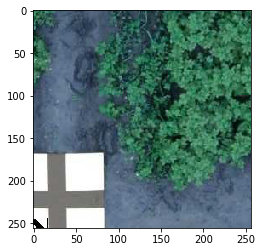

In [51]:
plt.imshow(x[0])

In [84]:
for index in range(4):
    img = pred[0, ..., index] / np.max(pred[0, ..., index])
    img *= 255.0
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.imwrite('segnet_{}.png'.format(index), img)
    
img = getClassesMap(pred[0]).astype(np.float32)
img = img / np.max(img)
img *= 255.0
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.imwrite('segnet_classes.png', img)

img = y[0].astype(np.float32)
img = y[0, ..., 0] * 0.0001 + y[0, ..., 1] * 1 + y[0, ..., 2] * 2 + y[0, ..., 3] * 3
img = img / np.max(img)
img *= 255.0
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.imwrite('segnet_gt.png', img)

True

In [78]:
np.min(pred[0, ..., 1]),np.max(pred[0, ..., 1])

(1.9893776e-05, 0.98673624)

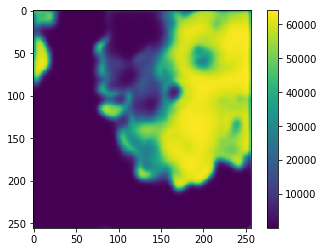

In [72]:
im_0_1 = plt.imshow(pred[0, ..., 1])
plt.colorbar(im_0_1)

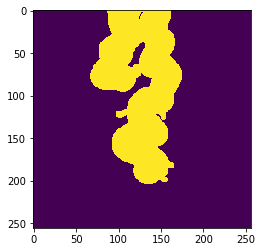

In [37]:
plt.imshow(y[0, ..., 2])

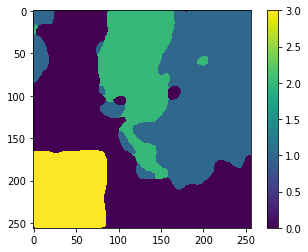

In [79]:
im_0_1 = plt.imshow(getClassesMap(pred[0]))
plt.colorbar(im_0_1)

In [21]:
sum(sum(getClassesMap(pred)))

30193

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0,0].imshow(x[0])
im_0_1 = axes[0][1].imshow(pred[0, ..., 0])

plt.colorbar(im_0_1, ax=axes[0,1])

In [31]:
pred = model1.predict(x)

pred[:,:,:,2] *= 2

In [23]:
ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 

In [24]:
ok_cnt, required, valid, errors

(57801,
 {0: 22460, 1: 21206, 2: 21870, 3: 0},
 {0: [19712, 0, 0, 0],
  1: [0, 19098, 0, 0],
  2: [0, 0, 18991, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 1802, 946, 0],
  1: [854, 0, 1254, 0],
  2: [811, 2068, 0, 0],
  3: [0, 0, 0, 0]})

### Estimate accuracy for validation set

In [25]:
all_ok_cnt = 0
all_required = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}
all_valid = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
all_errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}

for i in tqdm(range(len(data.valid.image_paths))):
    img_name = data.valid.image_paths[i]
    mask_name = data.valid.masks_paths[i]
    
    x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)
    
    pred = model1.predict(x)
#     pred[:,:,:,2] *= 2
    
    ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 
    
    all_ok_cnt += ok_cnt
    for j in range(4):
        all_required[j] = all_required[j] + required[j]
        all_valid[j] = [x + y for x, y in zip(all_valid[j], valid[j])]
        all_errors[j] = [x + y for x, y in zip(all_errors[j], errors[j])]

image_area = params.GetImageSize() * params.GetImageSize()
image_cnt = len(data.valid.image_paths)
scale = float(image_area * image_cnt) / 100.

all_ok_cnt /= scale
for j in range(4):
    all_required[j] /= scale
    all_valid[j] = [x / scale for x in all_valid[j]]
    all_errors[j] = [x / scale for x in all_errors[j]]

In [26]:
all_ok_cnt, all_required, all_valid, all_errors

(92.35712966918945,
 {0: 13.560565948486328,
  1: 77.02346954345703,
  2: 8.880536651611328,
  3: 0.5354278564453125},
 {0: [11.510083770751953, 0.0, 0.0, 0.0],
  1: [0.0, 73.49086456298828, 0.0, 0.0],
  2: [0.0, 0.0, 6.880725860595703, 0.0],
  3: [0.0, 0.0, 0.0, 0.47545547485351564]},
 {0: [0.0, 1.4074081420898437, 0.6161407470703125, 0.02693328857421875],
  1: [0.752044677734375, 0.0, 2.7117210388183595, 0.06883926391601562],
  2: [0.20487060546875, 1.794940185546875, 0.0, 0.0],
  3: [0.02498931884765625, 0.03495025634765625, 3.2806396484375e-05, 0.0]})